In [1]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

from model import ExponentialKernelFiringRateModel, PolynomialActivation
from evaluate import explained_variance_ratio
from data import get_data, get_train_test_data, preprocess_data

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
def get_activation_plot(actv, start=-100, end=270):
    currents = torch.linspace(start, end, steps=300).reshape(-1, 1)
    with torch.no_grad():
        fs = actv(currents)
    return currents.reshape(-1), fs.reshape(-1)

def plot_activation(Is, fs, actv):
    plt.figure(figsize=(8, 4.5), dpi=1000)
    plt.scatter(Is, fs)
    xs1, ys1 = get_activation_plot(actv, end=int(actv.max_current)+300)
    plt.plot(xs1, ys1, linewidth=2)
    plt.xlabel("$I$ $(pA)$")
    plt.ylabel("$g(I)$ $(ms^{-1})$")

def plot_kernel(model, cell_id, bin_size, save=False, fname=None, xlim=10):
    fig = plt.figure(constrained_layout=True, figsize=(8, 4.5), dpi=1000)
    subfigs = fig.subfigures(1, 2)
    #fig.suptitle(f"cell_id={cell_id}, bin_size={bin_size}")
    xs = torch.linspace(0, xlim, 100)
    cs, ds = [], []
    with torch.no_grad():
        for x in xs:
            cs.append(model.kernel(x, var="a"))
            ds.append(model.kernel(x, var="b"))
    
    xs = xs * bin_size / 1000
    
    axs0 = subfigs[0].subplots(2)
    axs0[0].plot(xs,cs, linewidth=2)
    axs0[1].plot(xs,ds, linewidth=2)
    axs0[0].set_ylabel("$k_I(t)$")
    axs0[1].set_ylabel("$k_f(t)$")
    axs0[0].set_ylim([0, 3.4])
    axs0[1].set_ylim([-3.4, 0])
    axs0[1].set_xlabel("$t$ $(s)$")
    
    axs1 = subfigs[1].subplots(2)
    taus = -20/np.log(1-np.array([0.0198, 0.1131, 0.4727, 0.9716, 1.0000]))
    ks = [f"{i:.2f}" for i in taus]
    axs1[0].bar(ks, model.a.detach().reshape(-1))
    axs1[1].bar(ks, model.b.detach().reshape(-1))
    axs1[0].set_ylabel("$\\alpha_i$")
    axs1[1].set_ylabel("$\\beta_i$")
    axs1[1].set_xlabel("$\\tau_i$ (ms)")
    
    #fig.set_size_inches(8, 4.5, forward=True)

    if save:
        plt.savefig(config["fig_save_path"] + f"{cell_id}/bin_size_{bin_size}/{fname}.png")
        plt.close()

def plot_predictions(model, Is, fs, cell_id, bin_size, evr=None, xlim=None):
    pred_fs, vs = model.predict(Is)
    pred_fs = torch.cat([torch.zeros(1), pred_fs])
    vs = torch.cat([torch.zeros(1, 5), vs])
    Is = torch.cat([torch.zeros(1), Is])
    fs = torch.cat([torch.zeros(1), fs])
    ts = np.arange(Is.shape[0]) * bin_size / 1000
    
    fig, axs = plt.subplots(2, figsize=(6, 2.5), dpi=1000)
    
    axs[1].plot(ts, fs, label="Actual", linewidth=1)
    axs[1].plot(ts, pred_fs, label="Predicted", linewidth=1)
    #axs[2].plot(ts, vs, linewidth=1)
    axs[0].plot(ts, Is, linewidth=1)
    axs[1].legend()
    axs[1].set_ylabel("$f_t$ $(ms^{-1})$")
    #axs[2].set_ylabel("$\mathbf{h}_t$")
    axs[0].set_ylabel("$I_t$ $(pA)$")
    if xlim is not None:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)
        #axs[2].set_xlim(xlim)
    #axs[0].yaxis.set_ticklabels([])
    #axs[1].yaxis.set_ticklabels([])
    axs[0].set_ylim([-10, 230])
    axs[1].set_ylim([-0.003, 0.06])
    axs[0].xaxis.set_ticklabels([])
    #axs[1].xaxis.set_ticklabels([])
    #axs[2].xaxis.set_ticklabels([])
    axs[1].set_xlabel("$t$ $(s)$")
    fig.tight_layout()

In [12]:
def get_dataset(params, threshold=0.6):
    with open("model/labels.pickle", "rb") as f:
        labels = pickle.load(f)
    
    chosen_ids = filter(lambda x: params[x]["evr2"] > threshold, params.keys())
    
    dataset = {}
    for cell_id in chosen_ids:
        y = labels[cell_id]
        p = params[cell_id]["params"]
        model = ExponentialKernelFiringRateModel.from_params(p)
        
        a = p["a"].reshape(-1)
        b = p["b"].reshape(-1)
        pc = p["g"]["poly_coeff"].reshape(-1)
        gb = p["g"]["b"].reshape(-1)
        mc = p["g"]["max_current"].reshape(-1)
        mfr = p["g"]["max_firing_rate"].reshape(-1)
        x = torch.cat([a, b, pc, gb, mc, mfr])
        
        dataset[cell_id] = (x, y, params[cell_id]["evr2"])
        
    return dataset
    
def get_params(bin_size, activation_bin_size, C, patch_seq=False):
    params = {}
    save_path = f"model/params/{bin_size}_{activation_bin_size}_{C}/"
    if patch_seq:
        save_path = f"model/params/patch_seq_{bin_size}_{activation_bin_size}_{C}/"
    for fname in os.listdir(save_path):
        if fname.endswith(".pickle"):
            cell_id = int(fname.split(".")[0])
            with open(f"{save_path}{fname}", "rb") as f:
                params[cell_id] = pickle.load(f)
    return params

def get_all_params():
    bin_sizes = [10, 20, 50, 100]
    activation_bin_sizes = [20, 100]
    C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
    params = {}
    
    for bin_size in bin_sizes:
        for activation_bin_size in activation_bin_sizes:
            if activation_bin_size >= bin_size:
                for c in C:
                    params[(bin_size, activation_bin_size, c)] = get_params(bin_size, activation_bin_size, c)
                                
    return params

# summarize params of one configuration
def summarize(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["train_losses"][-1])
        data["epochs"].append(len(params[cell_id]["train_losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")
    df_corrected = df[df["evr1"] > 0.01].dropna()
    
    if len(df) == 0:
        return {}
    
    return {
        "n_cells": len(df),
        "p_zero_evr": len(df[df['evr2'] < 0.01]) / len(df),
        "p_early_stop": len(df[df['epochs'] < 50]) / len(df),
        "corrected_median_evr": np.median(df_corrected['evr2'].values)
    }

def get_best_params_for_actv_bin_size(params, bin_size, actv_bin_size):
    best_params = {}
    
    cell_ids = set()
    for config in params:
        cell_ids = cell_ids.union(set(params[config].keys()))
    
    for cell_id in cell_ids:
        best_config = None
        best_evr = -1e10
        
        for config in params:
            if config[0] == bin_size and config[1] == actv_bin_size and cell_id in params[config] and params[config][cell_id]["evr1"] > best_evr:
                best_evr = params[config][cell_id]["evr1"]
                best_config = config
        
        # doesn't make sense
        if best_config is not None:
            best_params[cell_id] = params[best_config][cell_id]
        
    return best_params

def get_best_params(params, bin_size):
    best_params = {}
    
    cell_ids = set()
    for config in params:
        cell_ids = cell_ids.union(set(params[config].keys()))
    
    for cell_id in cell_ids:
        best_config = None
        best_evr = -1e10
        
        for config in params:
            if config[0] == bin_size and cell_id in params[config] and params[config][cell_id]["evr1"] > best_evr:
                best_evr = params[config][cell_id]["evr1"]
                best_config = config
        
        # doesn't make sense
        if best_config is not None:
            best_params[cell_id] = params[best_config][cell_id]
        
    return best_params

def visualize_data(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["train_losses"][-1])
        data["epochs"].append(len(params[cell_id]["train_losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")

    print(f"Total number of cells: {len(df)}")
    print(f"Number/proportion of cells with evr<=0: {len(df[df['evr2'] <= 0])}/{len(df[df['evr2'] <= 0]) / len(df)}")
    print(f"Number/proportion of cells with epochs<50: {len(df[df['epochs'] < 50])}/{len(df[df['epochs'] < 50]) / len(df)}")

    df_corrected = df[df["evr1"] > 0.01]
    print(f"Median evr: {np.median(df_corrected.dropna()['evr2'].values)}")

    evrs1 = df_corrected.iloc[:, 0]
    evrs2 = df_corrected.iloc[:, 1]
    losses = df_corrected.iloc[:, 2]

    plt.figure()
    plt.hist(evrs2, bins="auto")
    plt.xlabel("evr2")
    plt.ylabel("counts")
    plt.title("evr2 histogram (failed optimizations removed)")

    
    plt.figure()
    plt.hist(losses, bins="auto")
    plt.xlabel("loss")
    plt.ylabel("counts")
    plt.title("loss histogram (failed optimizations removed)")

    plt.figure()
    plt.scatter(evrs2, losses, alpha=0.5)
    plt.xlabel("evr2")
    plt.ylabel("loss")
    plt.title("evr2 vs loss scatter plot (failed optimizations removed)")

    plt.figure()
    plt.scatter(evrs1, evrs2, alpha=0.5)
    plt.xlabel("evr1")
    plt.ylabel("evr2")
    plt.title("evr1 vs evr2 scatter plot (failed optimizations removed)")
    
    return df

def summarize_all_models():
    all_params = get_all_params()
    summ = {}
    for config in all_params:
        summ[f"bin_size={config[0]}, activation_bin_size={config[1]}, C={config[2]}"] = summarize(all_params[config])
    for bin_size in [10, 20, 50, 100]:
        best_params = get_best_params(all_params, bin_size)
        summ[f"Best for {bin_size=}:"] = summarize(best_params)
    print(nice_dict(summ))
    
def nice_dict(d, indent=0):
    s = []
    for i in d:
        if type(d[i]) == dict:
            s.append(f"{i}\n{nice_dict(d[i], indent=indent+1)}")
        elif type(d[i]) == float:
            s.append(f"{i}: {d[i]:.4f}")
        else:
            s.append(f"{i}: {d[i]}")
    return "\n".join(["| "*indent + x for x in s])

In [11]:
params = get_all_params()

In [27]:
bin_size = 20
actv_bin_size = 20
params = get_best_params_for_actv_bin_size(params, bin_size, actv_bin_size)
dataset = get_dataset(params, threshold=0.5)
with open("data/dataset.pickle", "wb") as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
ps = []
for bin_size in [10, 20, 50, 100]:
    ps.append(get_best_params(params, bin_size))

In [14]:
evrs = {}
medians = []
bin_sizes = [10, 20, 50, 100]
for i, p in enumerate(ps):
    evr = []
    for cell_id in p:
        evr.append(p[cell_id]["evr2"])
    medians.append(np.median(evr))
    evrs[f"$\\Delta t={bin_sizes[i]}$"] = evr

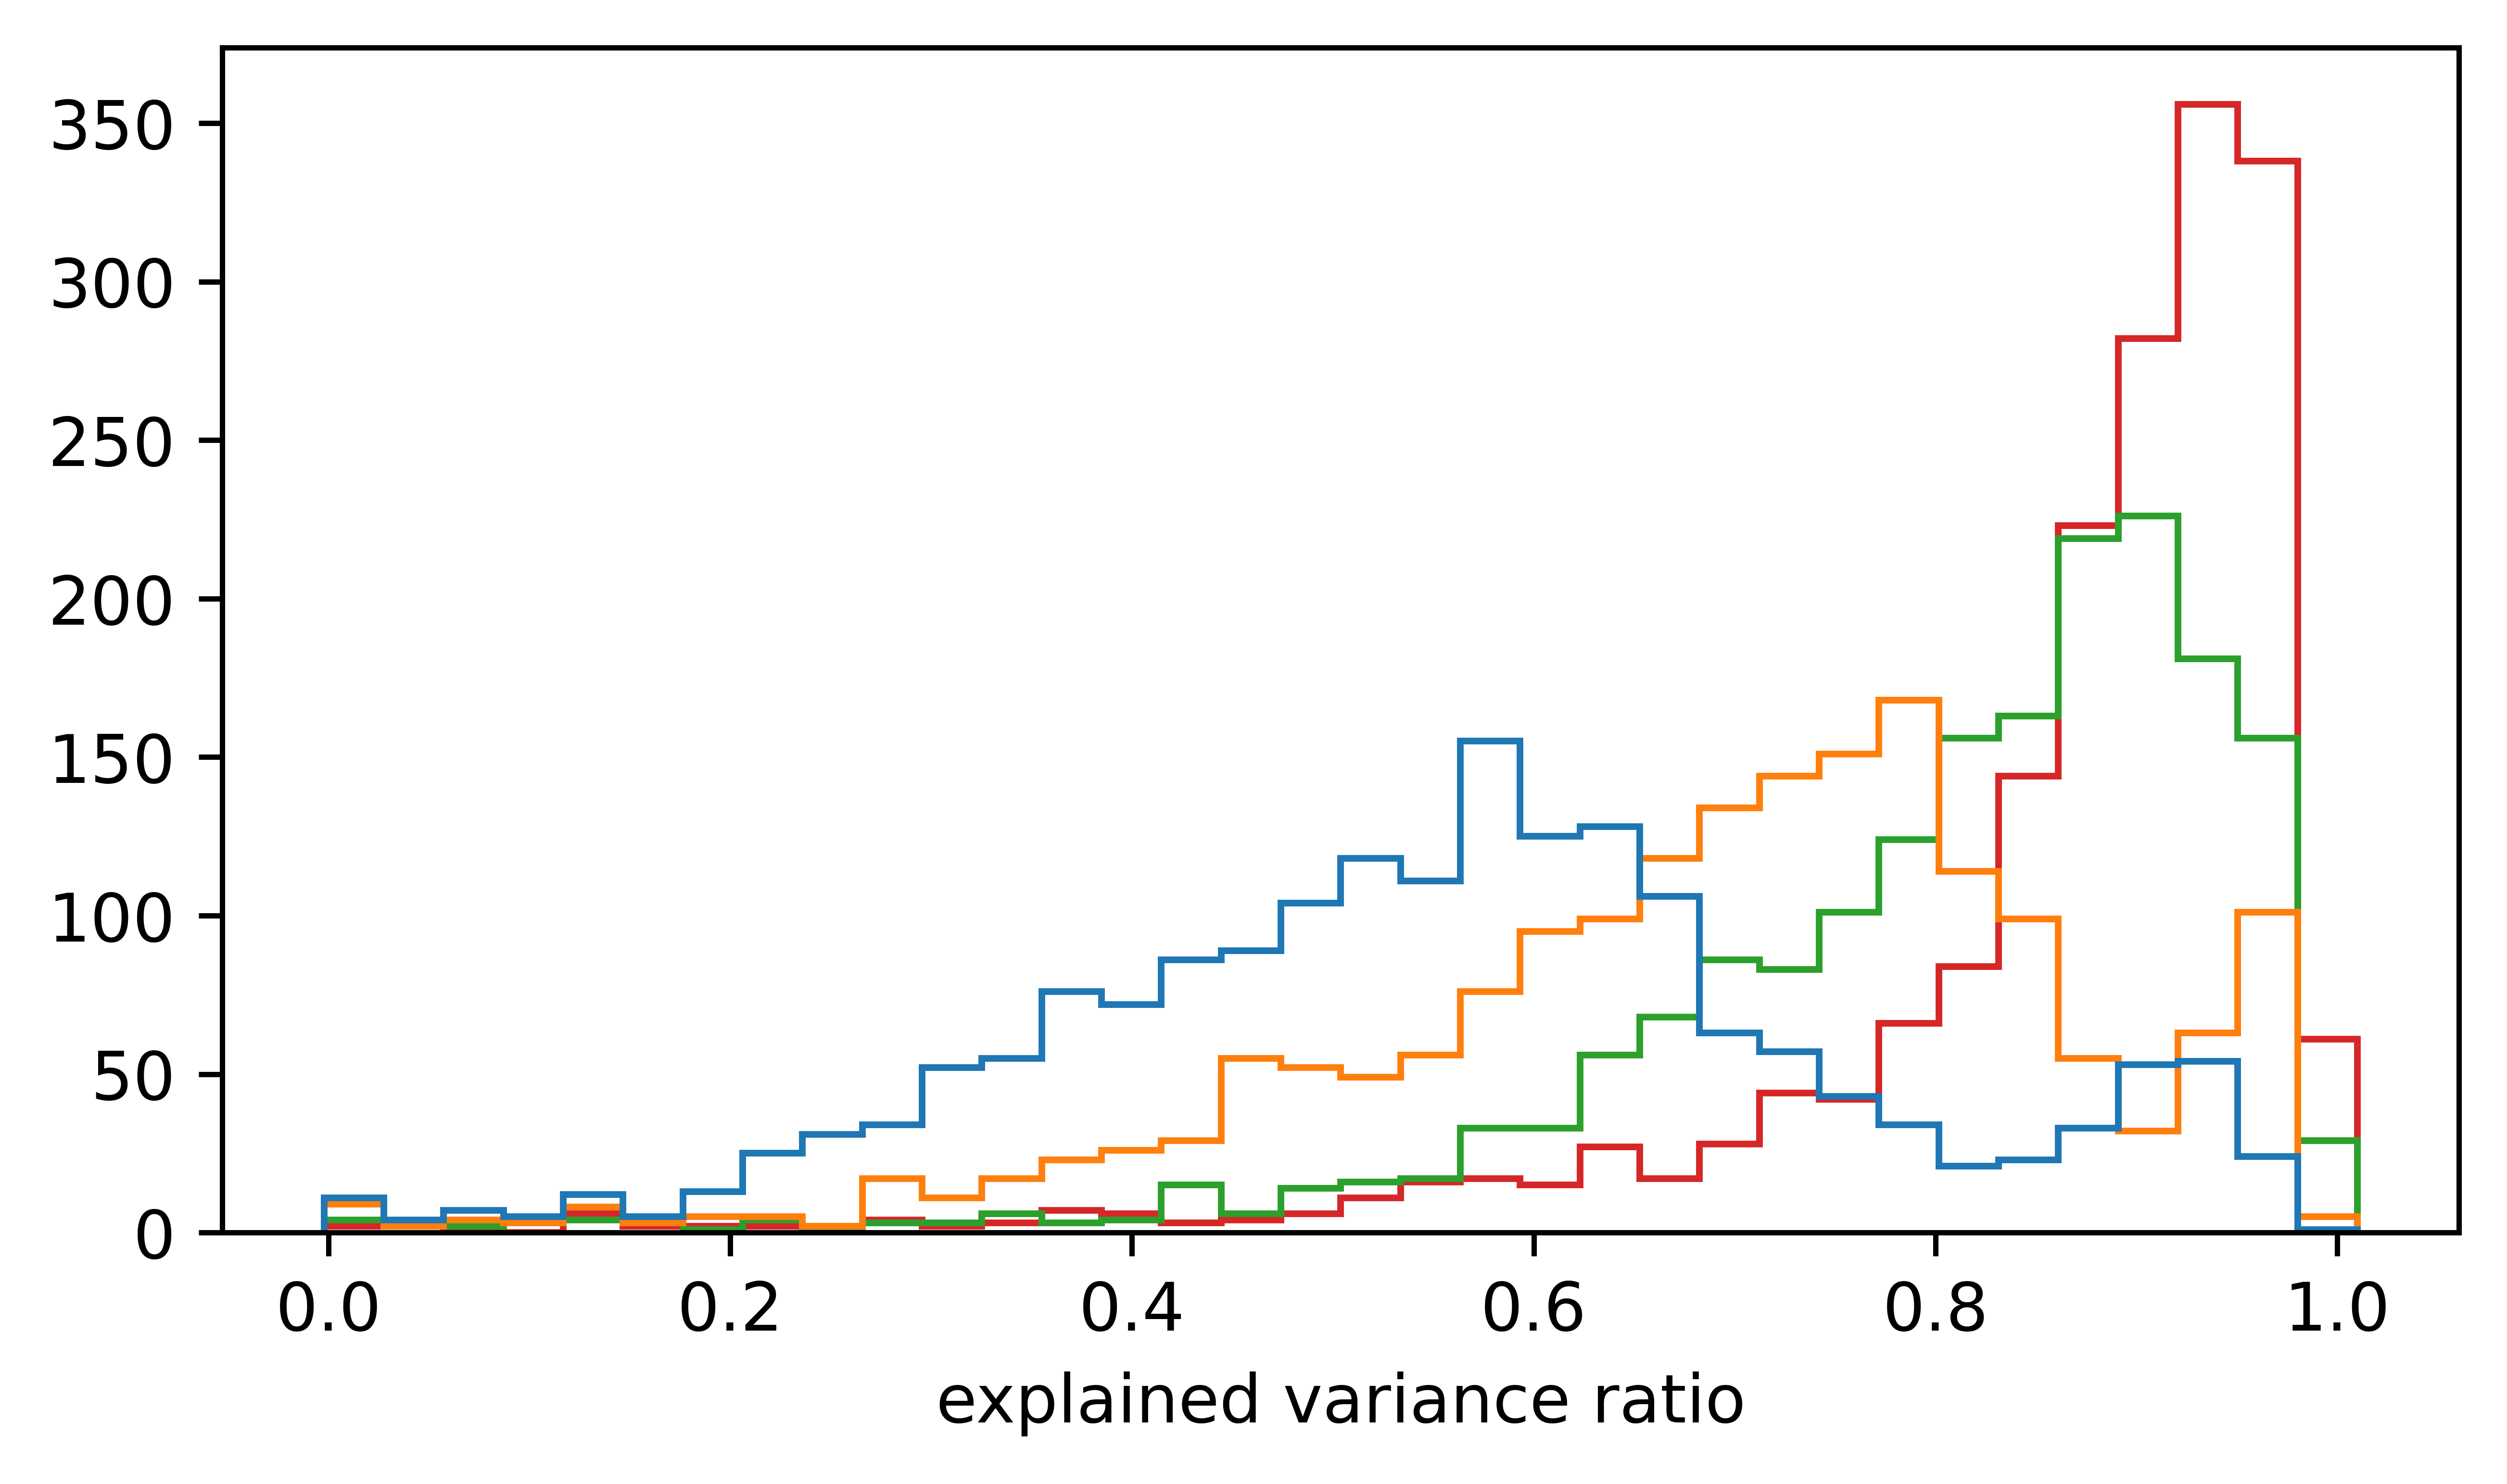

In [23]:
plt.figure(figsize=(6, 3.2), dpi=1000)
plt.hist(evrs.values(), histtype='step', bins="auto")
#p = sns.kdeplot(evrs, fill=False, clip=[0, 1])
plt.xlabel("explained variance ratio");
plt.show()

In [48]:
params = best_params
print(len(params))

1819


Total number of cells: 1819
Number/proportion of cells with evr<=0: 474/0.2605827377680044
Number/proportion of cells with epochs<50: 467/0.2567344694887301
Median evr: 0.7436390739892267


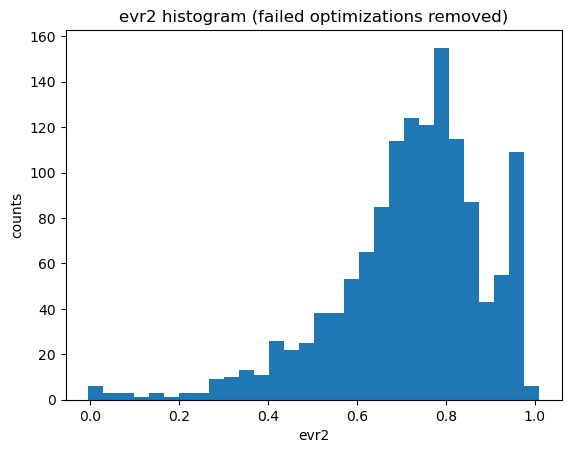

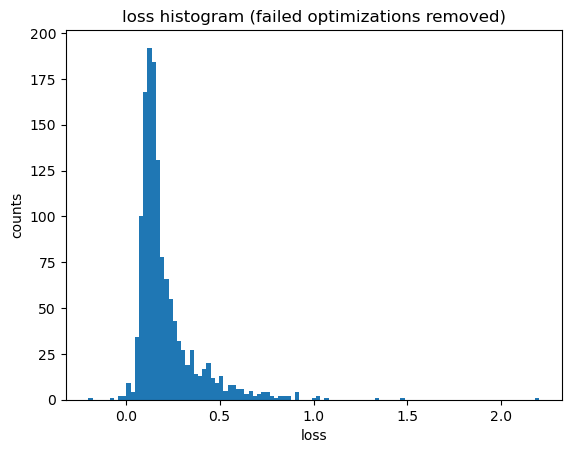

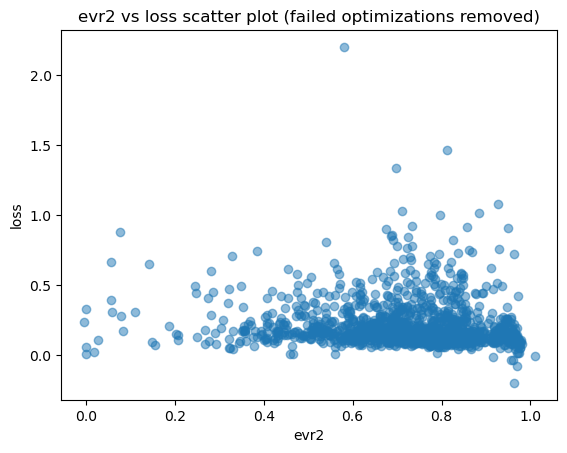

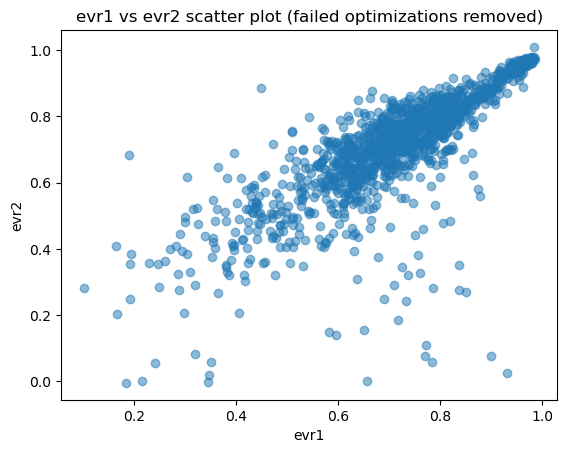

In [29]:
df = visualize_data(params)

In [35]:
print(df.index[-200:].tolist())

[593579697, 473564515, 475894121, 475549284, 582778095, 566978098, 569623233, 487176969, 485466109, 488501071, 584632767, 478795872, 508400236, 555042715, 572295788, 575637715, 522418855, 484635029, 477127614, 556914447, 322515253, 329254830, 557194325, 500859045, 574734127, 554807924, 570098371, 579660456, 581157315, 329322109, 488677994, 330080937, 500879695, 541536216, 539640410, 529807751, 584219169, 569270348, 534141324, 488685185, 488683322, 584215214, 528002420, 585952606, 488674910, 565871768, 560738452, 481127932, 643584386, 583454722, 509516379, 573622646, 581404810, 484742605, 609435731, 485245025, 475580568, 488711144, 585951863, 488230133, 490382353, 313862134, 643575207, 591639922, 583434059, 571715883, 482690728, 545192313, 561325425, 569072334, 475512108, 469614747, 585832440, 563620254, 572409429, 574059157, 586078695, 548444436, 478949560, 487594856, 572376830, 485061364, 471077857, 579662957, 485060618, 486352114, 482799345, 586358539, 554807988, 323452196, 396369826

In [18]:
def visualize(cell_id, params, bin_size=20):
    model = ExponentialKernelFiringRateModel.from_params(params[cell_id]["params"])
    data = get_data(cell_id, aligned=True)
    Is_tr, fs_tr, _, _, Is_te, fs_te, stims = get_train_test_data(data, bin_size)
    Is_actv, fs_actv = preprocess_data(data, bin_size=params[cell_id]["params"]["g"]["bin_size"])
    
    def _plot_train_data():
        for Is, fs, s in zip(Is_tr, fs_tr, stims):
            if torch.sum(fs) > 0.2:
                for i in range(Is.shape[0]):
                    plot_predictions(
                        model, 
                        Is[i, :], 
                        fs[i, :], 
                        cell_id, 
                        bin_size, 
                        evr = None
                    )
                
    def _plot_noise2():
        r = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size)
        print(Is_te[0][0, :].shape)
        plot_predictions(
            model, 
            Is_te[0][0, :], 
            fs_te[0][0, :], 
            cell_id, 
            bin_size, 
            evr = r,
            xlim = [15, 20]
        )
    
    def _plot_kernel():
        plot_kernel(
            model,
            cell_id,
            bin_size,
            save = False,
            xlim = 25
        )
    
    def _plot_activation():
        plot_activation(
            Is_actv,
            fs_actv,
            model.g
        )
    
    def _plot_losses():
        losses = params[cell_id]["losses"]
        plt.figure()
        plt.plot(list(range(len(losses))), losses)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        
    #_plot_train_data()
    #_plot_noise2()
    _plot_kernel()
    #_plot_activation()
    #_plot_losses()

/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_76352/2658066254.py:38: RuntimeWarning: divide by zero encountered in log
  taus = -20/np.log(1-np.array([0.0198, 0.1131, 0.4727, 0.9716, 1.0000]))


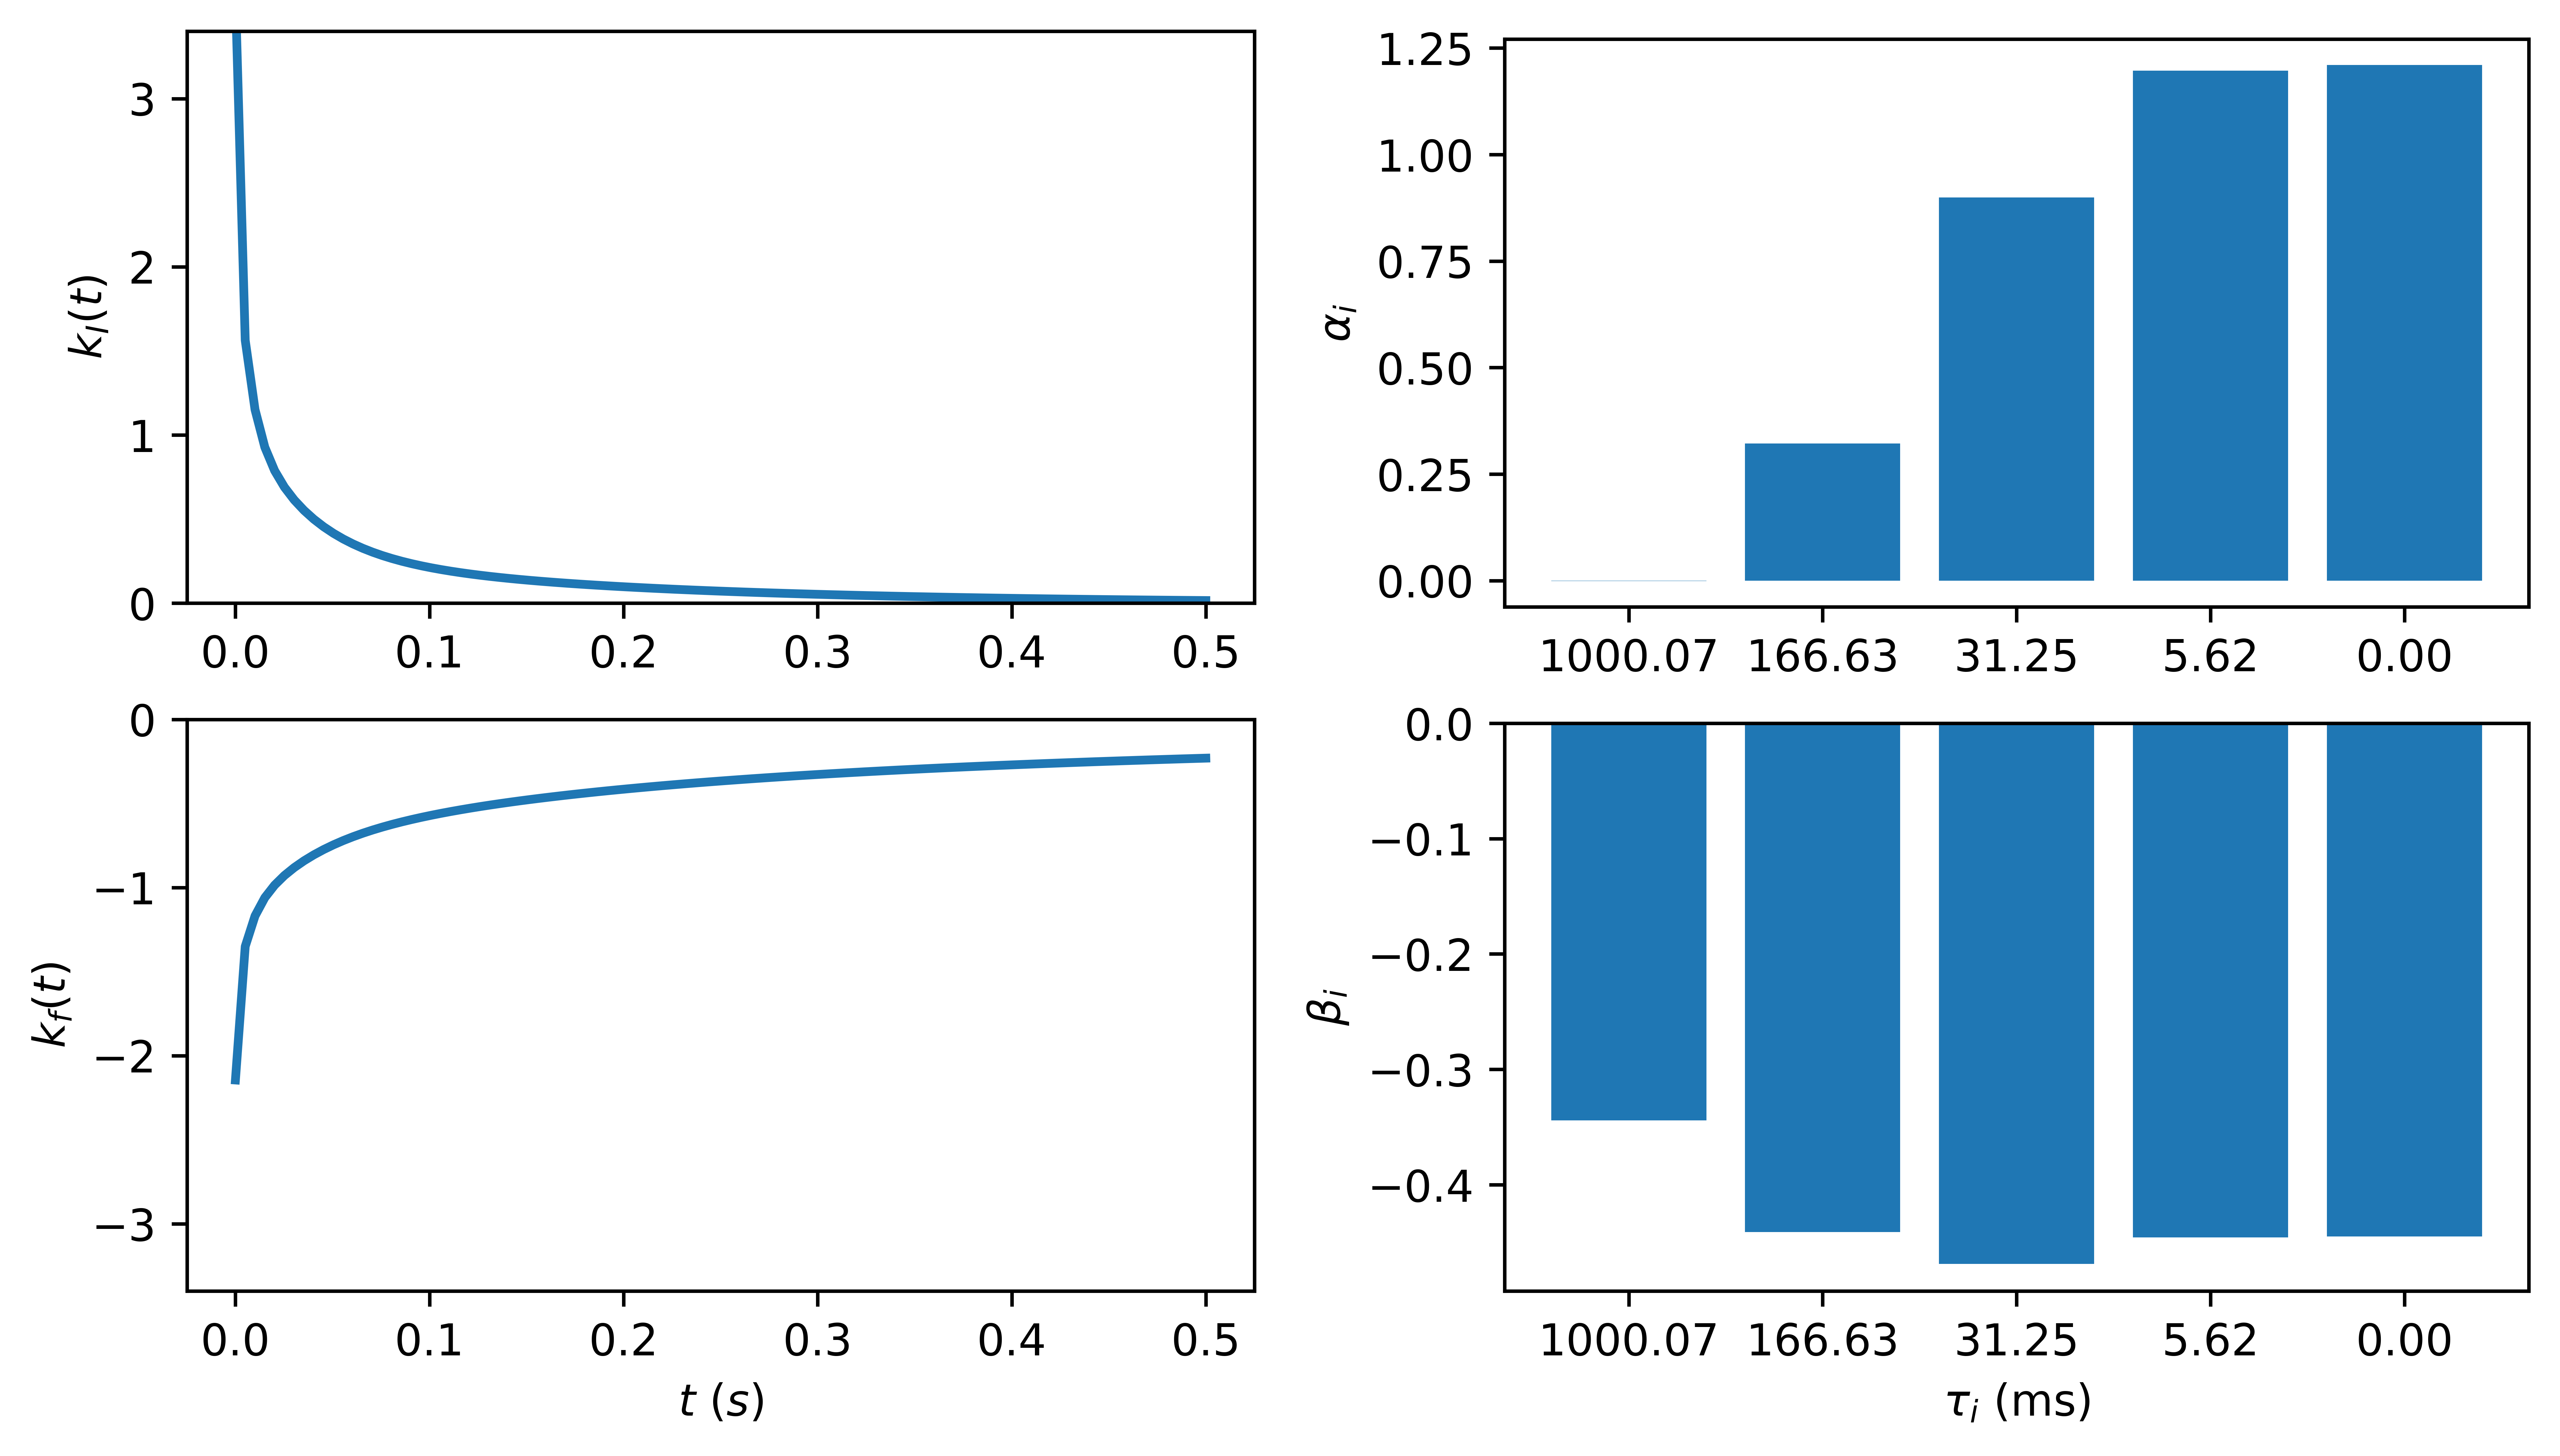

In [19]:
plt.rcParams.update({'figure.max_open_warning': 0})
visualize(557194325, params)